In [1]:
%matplotlib inline
import csv
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#object_observed = "USA 227 [37377, 2011-011A]"
#frequency = "2242.499"

#object_observed = "AEHF-2 [38254, 2012-019A]"
#frequency = "2267.512"

#object_observed = "USA 167 [27691, 2003-008A]"
#frequency = "2277.514"

#object_observed = "WGS-6 [39222, 2013-041A]"
#frequency = "2277.510"

#object_observed = "CBAS-2 [55263, 2023-008A]"
#frequency = "2277.500"

#object_observed = "STPSAT-6 [49817, 2021-118A]"
#frequency = "2257.912"

#object_observed = "SLIM [57803, 2023-137D]"
#frequency = "2212.000"

#object_observed = "GOES 17 [43226, 2018-022A]"
#frequency = "2211.056"

#object_observed = "SIRIUS FM-6 [39360, 2013-058A]"
#frequency = "2330.200"
#frequency = "2342.200"

#object_observed = "Zenith AZ:180 EL:90"
#frequency = "2295.000"

#object_observed = "SBIRS GEO 6 [53355, 2022-092A]"
#frequency = "2237.516"
#frequency = "2252.500"

#object_observed = "SBIRS GEO 4 [41937, 2017-004A]"
#frequency = "2237.518"
#frequency = "2262.500"

object_observed = "DSCOVR [40390, 2015-007A]"
frequency = "2215.00"

#object_observed = "GOES 18 [51850, 2022-021A]"
#frequency = "2211.056"

# EUTE 7A is LHCP
#object_observed = "EUTE 7A [28187, 2004-008A]"
#frequency = "2265.384"

#object_observed = "GOES 14 [35491, 2009-033A]"
#frequency = "2208.986"

#object_observed = "GPS BIIF-11 (PRN 10) [41019, 2015-062A]"
#object_observed = "GPS BIIF-12 (PRN 32) [41328, 2016-007A]"
#object_observed = "GPS BIIF-10 (PRN 08) [40730, 2015-033A]"
#object_observed = "GPS BIIR-9  (PRN 21) [22704,2003-010A]" NOT ACTIVE
#object_observed = "GPS BIIR-13 (PRN 02) [28474,2004-045A]" 
#object_observed = "GPS BIIRM-2 (PRN 31) [29486, 2006-042A]" NOT ACTIVE
#object_observed = "GPS BIII-6 (PRN 28) [55268, 2023-009A]" 
#object_observed = "GPS BIIF-8 (PRN 03) [40294, 2014-068A]"
#object_observed = "GPS BIII-1 (PRN 04) [43873, 2018-109A]"
#object_observed = "GPS BIIF-7 (PRN 09) [40105, 2014-045A]"
#object_observed = "GPS BIIRM-6 (PRN 07) [32711, 2008-012A]" NOT ACTIVE
#object_observed = "GPS BIIF-5 (PRN 30) [39533, 2014-008A]"
#object_observed = "GPS BIII-4 (PRN 14) [46826, 2020-078A]"
#object_observed = "GPS BIIR-11 (PRN 19) [28190, 2004-009A]"Need to review.  
#object_observed = "GPS BIIF-6 (PRN 06) [39741, 2014-026A]" #ECLIPSE +/- 1.7MHz comes on
#object_observed = "GPS BIII-5  (PRN 11) [48859, 2021-054A]"
#object_observed = ""


#object_observed = "USA 149 [26356 2000-024A]"
#frequency = "2237.46"

#object_observed = "JWST"
#frequency = "2270.53"
#object_observed ="Calibration Source"
#frequency = "2211.056"

In [3]:
def datetime_to_mjd(t):
    mjd_epoch=np.datetime64('1858-11-17T00:00:00')
    time_differences = t - mjd_epoch
    mjd_values = time_differences / np.timedelta64(1, 'D')
    return mjd_values

def find_peak_frequencies(xy, frequency_values):
    magnitudes = np.abs(xy)    
    peak_frequency_indices = np.argmax(magnitudes, axis=1)
    peak_frequencies = frequency_values[peak_frequency_indices]
    return peak_frequencies

def calculate_fft(data, sample_rate):
    n = len(data)
    fft_result = np.fft.fft(data)
    freq = np.fft.fftfreq(n, 1 / sample_rate)
    return freq, fft_result

In [4]:
# plot variables
mark_size = 5

# gnuradio settings
nfft = 4096
samp_rate = 1e6
decim1 = 16
integ = 10

integrate = int(samp_rate/decim1/nfft*integ)
print(integrate) # print this to double check :-)

#observation details
site = 8049


directory_path = '/home/scott/blade_test/'

filename_pattern = '*.xx.f32'

latest_file = max(glob.glob(os.path.join(directory_path, filename_pattern)), key=os.path.getctime)

filename_parts = os.path.basename(latest_file).split('.')[0].split('_')
date_str = filename_parts[0]  # Format: yyyy-mm-ddThh:mm:ss

date_format = "%Y-%m-%dT%H:%M:%S"
datetime_obj = datetime.strptime(date_str, date_format)
formatted_datetime = datetime_obj.strftime("%Y-%m-%dT%H:%M:%S")

xx = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xx.f32'), dtype='float32').reshape((-1, nfft))
yy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.yy.f32'), dtype='float32').reshape((-1, nfft))
xy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xy.c64'), dtype='complex64').reshape((-1, nfft))

t = np.arange(xx.shape[0]) * integrate * nfft * decim1 / samp_rate * 1e3 * np.timedelta64(1, 'ms') + np.datetime64(datetime_obj)
print("Latest Filename:", latest_file)
print("Datetime:", datetime_obj)


152
Latest Filename: /home/scott/blade_test/2023-10-21T20:25:03.xx.f32
Datetime: 2023-10-21 20:25:03


peak frequency 2214992401.123047
Column Index for Peak Value: 1550
Gain Offset: 0.70205855
shape of XY:  (1338, 4096)
Column Index for Peak Value: 1534
Complex Phase Angle (Degrees) of Peak Value: 67.70696856304106
peak frequency 2214992156.982422


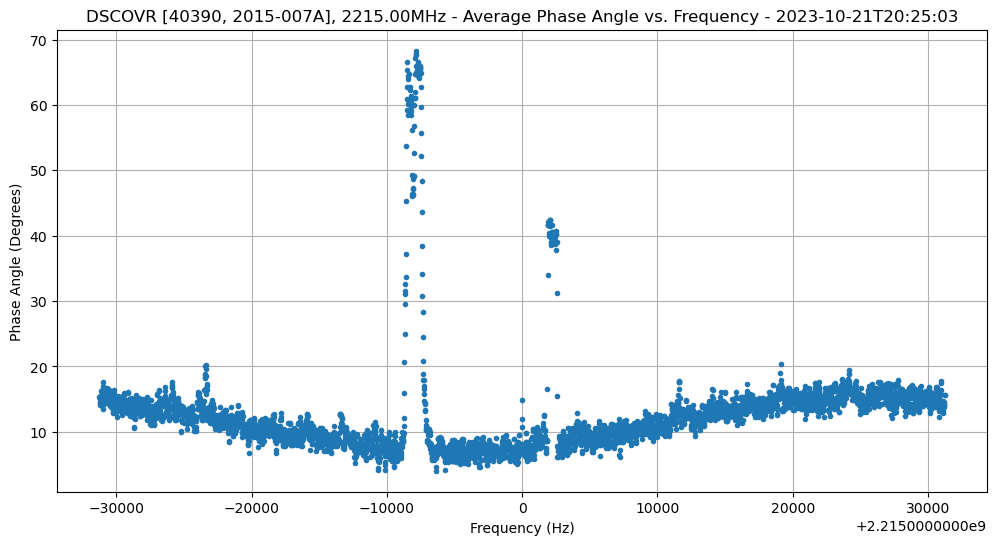

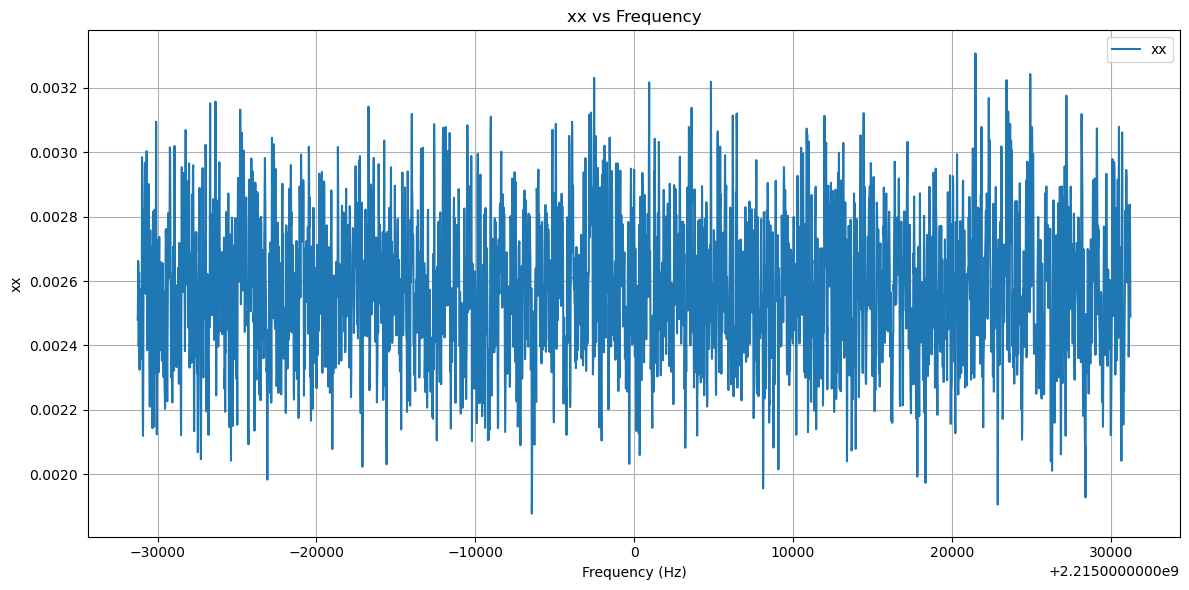

In [5]:
frequency_values = np.arange((samp_rate/decim1)/-2.0, (samp_rate/decim1)/2.0, (samp_rate/decim1)/nfft)
frequency_values += float(frequency) *1e6

peak_column_index = np.argmax(np.max(np.abs(xx), axis=0))
#xx_peak = xx[:, peak_column_index]
#yy_peak = yy[:, peak_column_index]
#gain_offset = np.average(xx_peak / yy_peak)
#print(gain_offset)

gain_offset = 0.70205855



print("peak frequency", frequency_values[peak_column_index])
print("Column Index for Peak Value:", peak_column_index)
print("Gain Offset:", gain_offset)
print("shape of XY: ", np.shape(xy))
yy *= gain_offset
xy *= np.sqrt(gain_offset)

n_rows,n_col = xy.shape
avg_complex_value = 0
for _ in range(n_rows):
    avg_complex_value += np.mean(xy, axis=0)
avg_complex_value /= n_rows
peak_value = np.max(np.abs(avg_complex_value))
peak_column_index = np.argmax(np.abs(avg_complex_value)) 
phase_angle_degrees = np.angle(avg_complex_value[peak_column_index], deg=True)
print("Column Index for Peak Value:", peak_column_index)
print("Complex Phase Angle (Degrees) of Peak Value:", phase_angle_degrees)

# NOTE: DSCOVR is LHCP, so using its phase to calibrate while keeping circular polarization convention.
#xy *= np.exp(-1j*np.deg2rad(phase_angle_degrees+180))*(-1j) # correct for X-Y phase offset


print("peak frequency", frequency_values[peak_column_index])

plt.figure(figsize=(12, 6))
#plt.ylim(phase_angle_degrees-10,phase_angle_degrees+10)
plt.plot(frequency_values, np.angle(avg_complex_value, deg=True), '.')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Angle (Degrees)')
plt.title(f'{object_observed}, {frequency}MHz - Average Phase Angle vs. Frequency - {formatted_datetime}')
plt.grid(True)

filename = f'{object_observed}_{formatted_datetime}_avg_phase_freq.png'
plt.savefig(filename)

# 2211.056e6, 0.5795452, -81.5
# 2228.520e6, 0.4101715, -48.0
xy *= np.exp(-1j*np.deg2rad(-74.5))*(-1j) # correct for X-Y phase offset

plt.figure(figsize=(12, 6))
plt.plot(frequency_values, xx[-1, :], label='xx', markersize=mark_size)
plt.title('xx vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('xx')
plt.grid(True)
plt.legend()
plt.tight_layout()

filename = f'{object_observed}_{formatted_datetime}_xx_freq.png'
plt.savefig(filename)

Minimum Value: -29.34687614440918
Maximum Value: -14.692058563232422
19651.85072916667 19652.004878333333


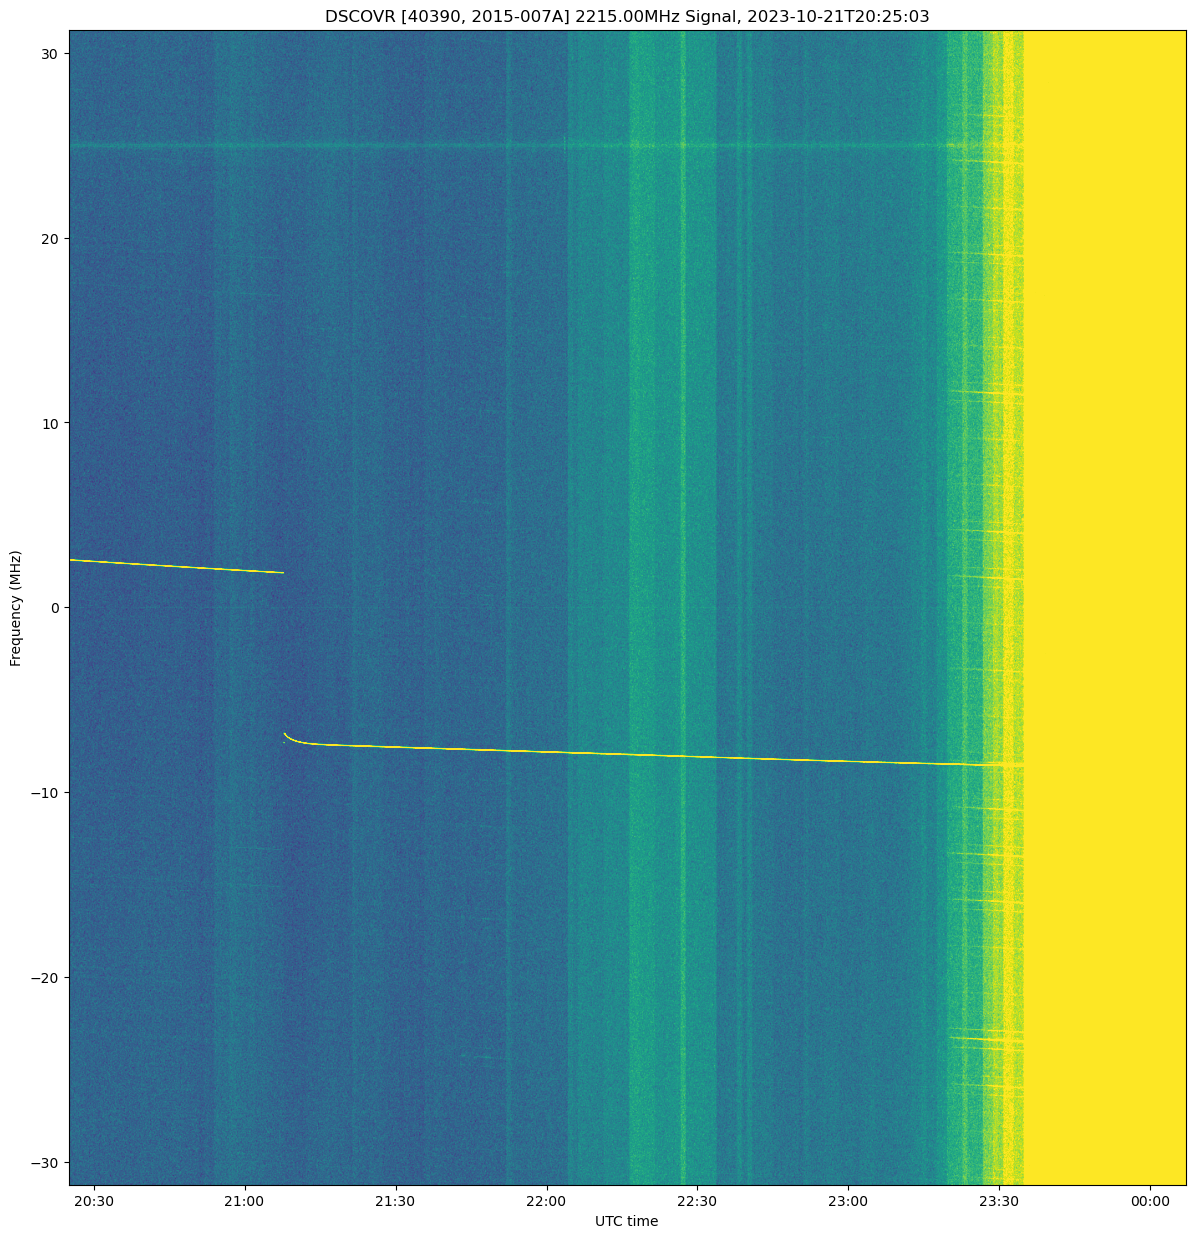

In [20]:
result = xx + yy
min_value = 10*np.log10(np.min(result))
max_value = 10*np.log10(np.max(result))
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)
print (mdates.date2num(t[0]),mdates.date2num(t[-1]))
#xaxis = mdates.date2num(t[-1]) - mdates.date2num(t[0])
#yaxis = np.max(frequency_values) - np.max(frequency_values)
#ratio = yaxis / xaxis

plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(10*np.log10(xx+yy)[:,::-1].T, extent = (mdates.date2num(t[0]),mdates.date2num(t[-1]), -31.25, 31.25),
          aspect =25.5e-4, vmin =-29, vmax = -25)
plt.gca().set_xlim((t[0], t[-1]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Frequency (MHz)')
plt.xlabel('UTC time')

title_text = f'{object_observed} {frequency}MHz Signal, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_sig_plot.png'
plt.savefig(filename)

In [7]:
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)
signal_xx = np.zeros(xx.shape[0])
signal_yy = np.zeros(yy.shape[0])
signal_xy = np.zeros(xy.shape[0], dtype = 'complex')
for offset in np.arange(-2,3):
    signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_xy += xy[np.arange(signal_peak.shape[0]), signal_peak + offset]
signal_xx /= offsets.size
signal_yy /= offsets.size
signal_xy /= offsets.size
gain_xx_yy = np.median(signal_xx + signal_yy)
signal_xx /= gain_xx_yy
signal_yy /= gain_xx_yy
signal_xy /= gain_xx_yy

In [8]:
I = signal_xx + signal_yy
Q = signal_xx - signal_yy
U = 2*signal_xy.real
V = -2*signal_xy.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

2023-10-21T20:25:03.dat


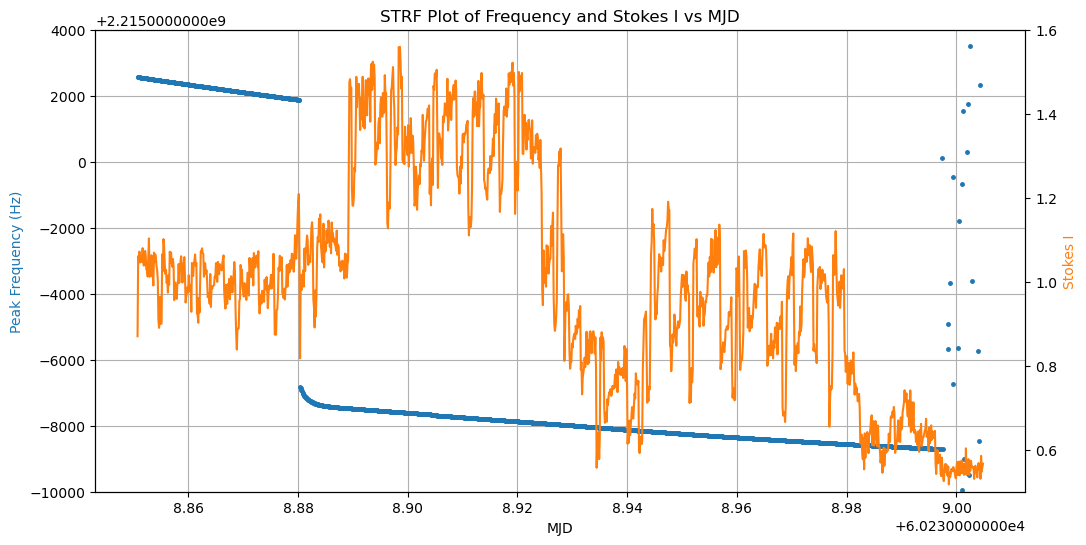

In [9]:
# STRF output in MJD, Peak_Frequency, Stokes I(dB), obs_site
n_rows = xy.shape[0]  # Replace 'xy' with your actual array
site_array = np.full((n_rows,), site)
rows = zip(datetime_to_mjd(t), find_peak_frequencies(xy, frequency_values), I, site_array)

output_file = f'{formatted_datetime}.dat'
print(output_file)

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerows(rows)

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
ax2 = ax1.twinx()  # Create a new y-axis on the right

# Plot Peak Frequency (blue) on the left y-axis
ax1.plot(datetime_to_mjd(t), find_peak_frequencies(xy, frequency_values), '.', markersize=mark_size, color='C0')
ax1.set_xlabel('MJD')
ax1.set_ylabel('Peak Frequency (Hz)', color='C0')
ax1.grid(True)

# Plot Stokes I (orange) on the right y-axis
ax2.plot(datetime_to_mjd(t), I,  markersize=mark_size, color='C1')
ax2.set_ylabel('Stokes I', color='C1')

# Set Y-axis limits for both axes
ax1.set_ylim(2214.990e6, 2215.004e6)  # Adjust the limits as needed
ax2.set_ylim(0.5,1.6)  # Adjust the limits as needed

plt.title('STRF Plot of Frequency and Stokes I vs MJD')

filename = f'{object_observed}_{formatted_datetime}_STRF.png'
plt.savefig(filename)




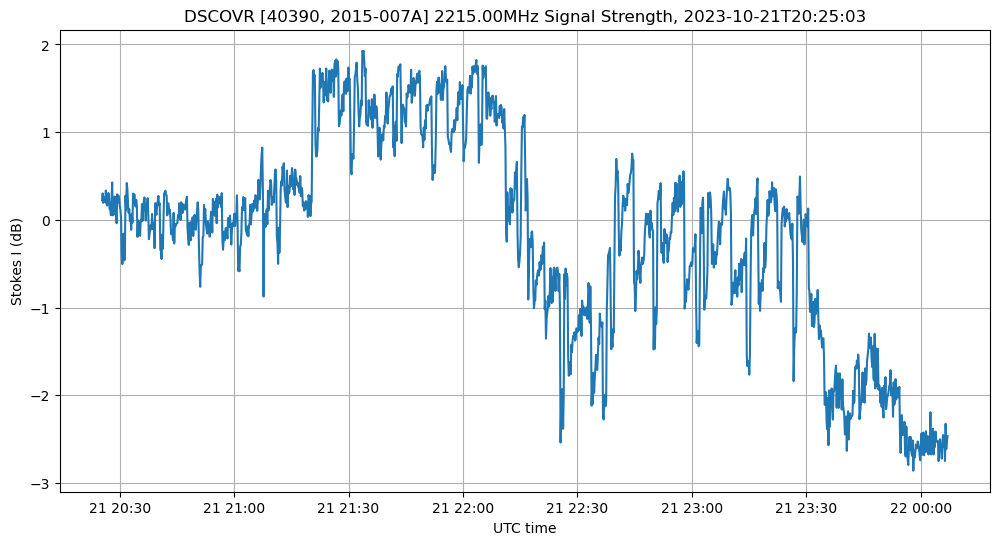

In [10]:
sel = slice(2,None)
y_min = -5  # Set your desired minimum Y value
y_max = 2   # Set your desired maximum Y value

plt.figure(figsize=(12, 6))
plt.grid(True)

plt.plot(t[sel], 10 * np.log10(I[sel]))
plt.ylabel('Stokes I (dB)')
plt.xlabel('UTC time')

# Set the Y-axis limits
#plt.ylim(y_min, y_max)

title_text = f'{object_observed} {frequency}MHz Signal Strength, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_sig_strength.png'
plt.savefig(filename)


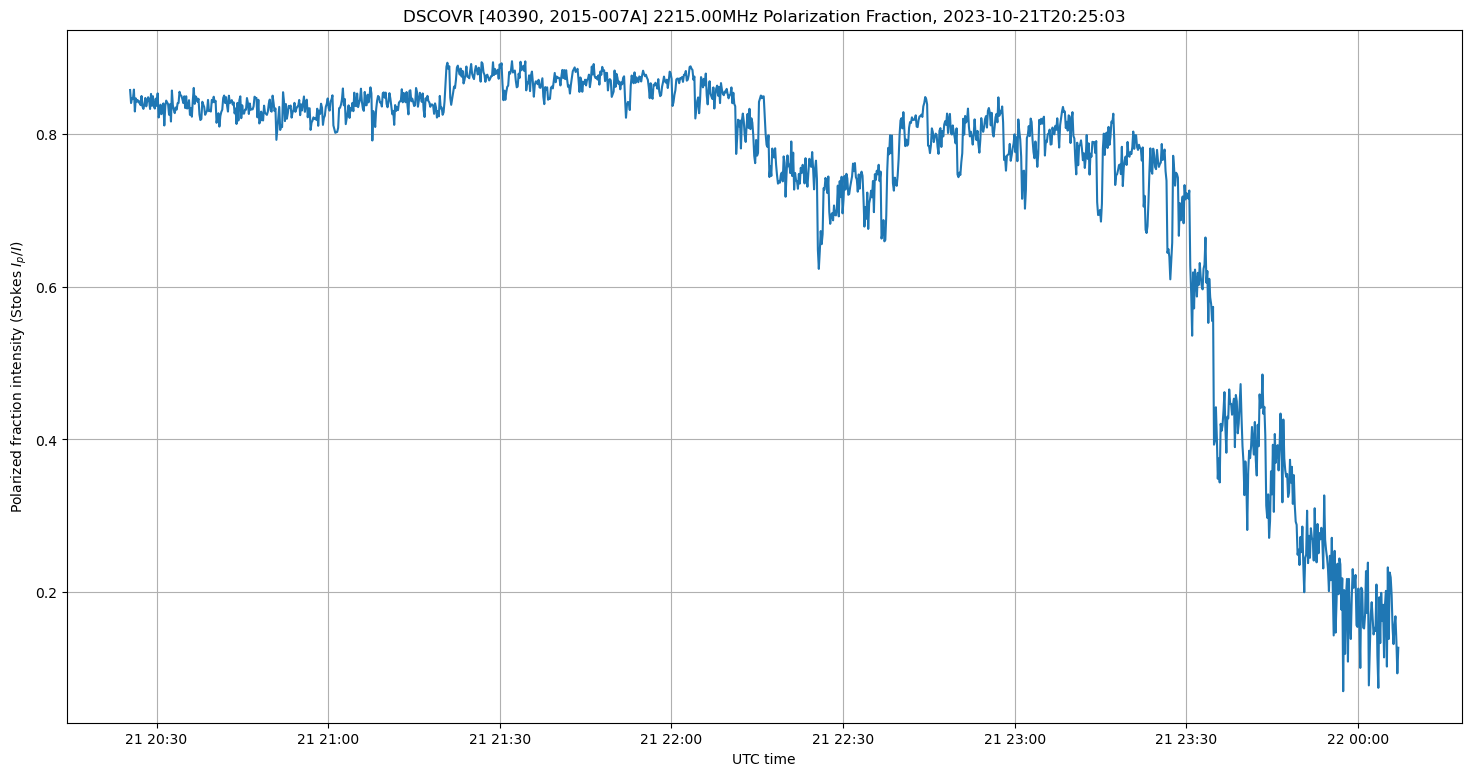

In [11]:
plt.figure(figsize = (18, 9))
plt.grid(True)

plt.plot(t[sel], (P/I)[sel])
plt.xlabel('UTC time')
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$)')
title_text = f'{object_observed} {frequency}MHz Polarization Fraction, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_pol_frac.png'
plt.savefig(filename)

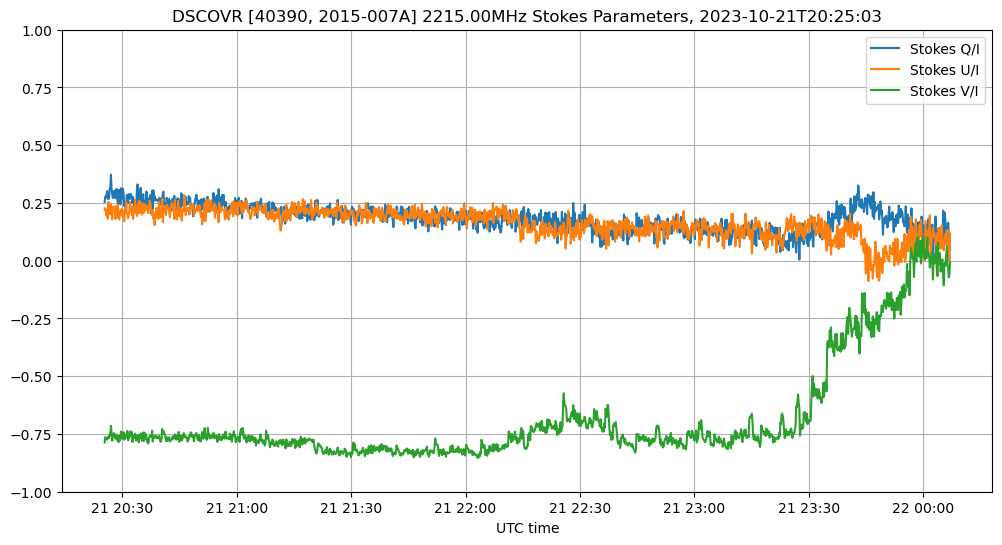

In [12]:
mark_size = 5
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.ylim(-1, 1)
plt.plot(t[sel], (Q/I)[sel],markersize=mark_size)
plt.plot(t[sel], (U/I)[sel],  markersize=mark_size)
plt.plot(t[sel], (V/I)[sel],  markersize=mark_size)
legend = plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
for handle in legend.legendHandles:
    handle.set_markersize(10)  # Adjust the marker size as needed
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_par.png'
plt.savefig(filename)

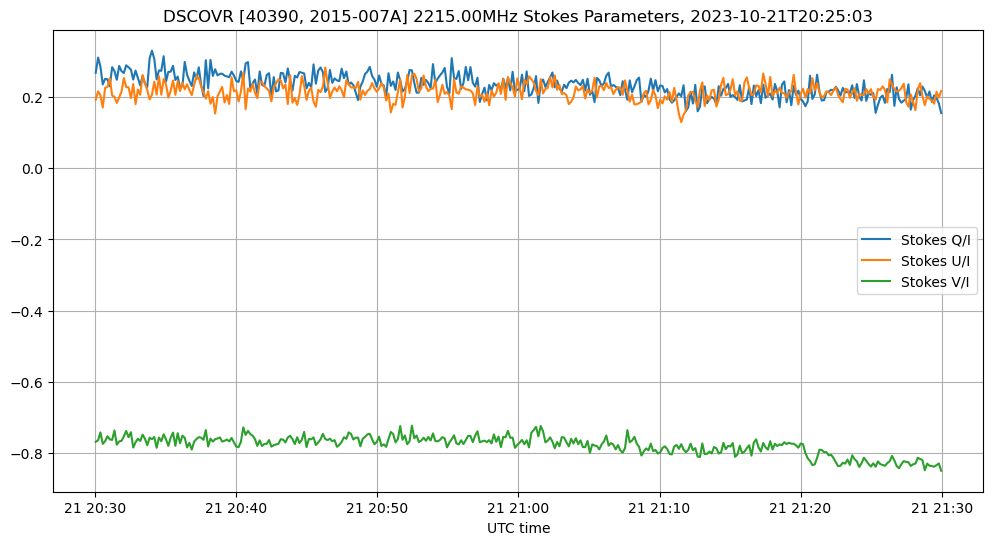

In [13]:
mark_size = 5

start_time = np.datetime64('2023-10-21T20:30:00')
end_time = np.datetime64('2023-10-21T21:30:00')

# Filter the data to select the data within the specified time range
time_range_filter = (t >= start_time) & (t <= end_time)
filtered_t = t[time_range_filter]
filtered_Q = Q[time_range_filter]
filtered_U = U[time_range_filter]
filtered_V = V[time_range_filter]
filtered_I = I[time_range_filter]

plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(filtered_t, (filtered_Q/filtered_I),  markersize=mark_size)
plt.plot(filtered_t, (filtered_U/filtered_I),  markersize=mark_size)
plt.plot(filtered_t, (filtered_V/filtered_I),  markersize=mark_size)
legend = plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
for handle in legend.legendHandles:
    handle.set_markersize(10)  # Adjust the marker size as needed
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_par_zoom.png'
plt.savefig(filename)


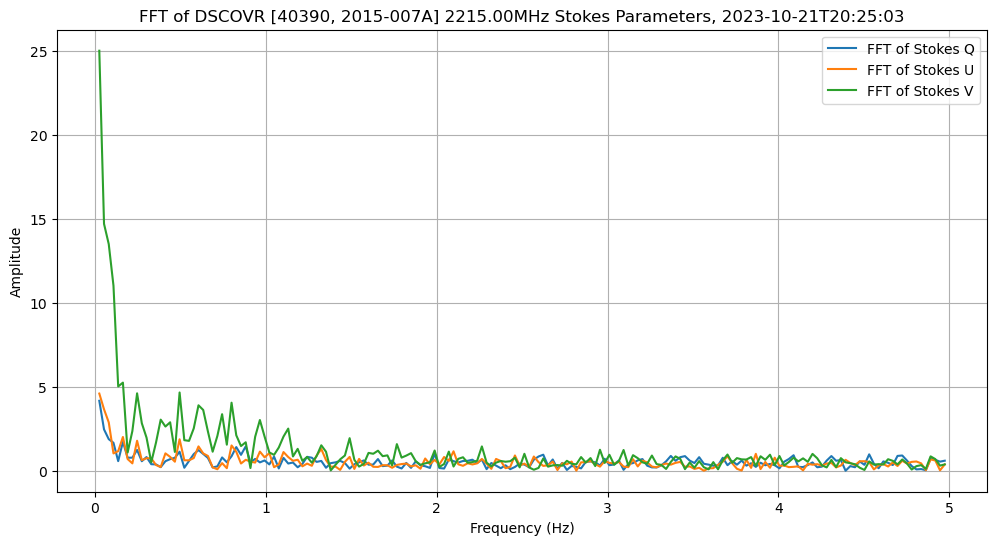

In [14]:
sample_rate = integ

freq_Q, fft_Q = calculate_fft(filtered_Q, sample_rate)
freq_U, fft_U = calculate_fft(filtered_U, sample_rate)
freq_V, fft_V = calculate_fft(filtered_V, sample_rate)

# Keep only the positive frequencies and filter out zeros
positive_freq_Q = freq_Q[(freq_Q >= 0) & (freq_Q != 0)]
positive_fft_Q = np.abs(fft_Q[(freq_Q >= 0) & (freq_Q != 0)])
positive_freq_U = freq_U[(freq_U >= 0) & (freq_U != 0)]
positive_fft_U = np.abs(fft_U[(freq_U >= 0) & (freq_U != 0)])
positive_freq_V = freq_V[(freq_V >= 0) & (freq_V != 0)]
positive_fft_V = np.abs(fft_V[(freq_V >= 0) & (freq_V != 0)])

# Continue with the plotting code
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(positive_freq_Q, positive_fft_Q, markersize=mark_size)
plt.plot(positive_freq_U, positive_fft_U, markersize=mark_size)
plt.plot(positive_freq_V, positive_fft_V, markersize=mark_size)


# Add legends
legend = plt.legend(['FFT of Stokes Q', 'FFT of Stokes U', 'FFT of Stokes V'])
for handle in legend.legendHandles:
    handle.set_markersize(10)  # Adjust the marker size as needed

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
title_text = f'FFT of {object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_fft.png'
plt.savefig(filename)

plt.show()

In [15]:
# Calculate average threshold for peak detection
average_threshold_Q = np.mean(positive_fft_Q)
average_threshold_U = np.mean(positive_fft_U)
average_threshold_V = np.mean(positive_fft_V)

# Find peaks in the FFT above the average threshold
peaks_Q, _ = find_peaks(positive_fft_Q, height=average_threshold_Q)
peaks_U, _ = find_peaks(positive_fft_U, height=average_threshold_U)
peaks_V, _ = find_peaks(positive_fft_V, height=average_threshold_V)

# Sort peaks by amplitude in descending order
peaks_Q_sorted = peaks_Q[np.argsort(positive_fft_Q[peaks_Q])][::-1]
peaks_U_sorted = peaks_U[np.argsort(positive_fft_U[peaks_U])][::-1]
peaks_V_sorted = peaks_V[np.argsort(positive_fft_V[peaks_V])][::-1]

# Print the frequency, period, and amplitude of the three greatest peaks for Q
print("Greatest Peaks in FFT of Stokes Q (Frequency, Period, Amplitude):")
for peak_index in peaks_Q_sorted[:3]:
    frequency_Q = positive_freq_Q[peak_index]
    period_Q = 1 / frequency_Q
    amplitude_Q = positive_fft_Q[peak_index]
    print(f"Frequency: {frequency_Q} Hz, Period: {period_Q} seconds, Amplitude: {amplitude_Q} ")

# Print the frequency, period, and amplitude of the three greatest peaks for U
print("Greatest Peaks in FFT of Stokes U (Frequency, Period, Amplitude):")
for peak_index in peaks_U_sorted[:3]:
    frequency_U = positive_freq_U[peak_index]
    period_U = 1 / frequency_U
    amplitude_U = positive_fft_U[peak_index]
    print(f"Frequency: {frequency_U} Hz, Period: {period_U} seconds, Amplitude: {amplitude_U} ")

# Print the frequency, period, and amplitude of the three greatest peaks for V
print("Greatest Peaks in FFT of Stokes V (Frequency, Period, Amplitude):")
for peak_index in peaks_V_sorted[:3]:
    frequency_V = positive_freq_V[peak_index]
    period_V = 1 / frequency_V
    amplitude_V = positive_fft_V[peak_index]
    print(f"Frequency: {frequency_V} Hz, Period: {period_V} seconds, Amplitude: {amplitude_V} ")

Greatest Peaks in FFT of Stokes Q (Frequency, Period, Amplitude):
Frequency: 0.16574585635359115 Hz, Period: 6.033333333333333 seconds, Amplitude: 1.7530136677589954 
Frequency: 0.8839779005524862 Hz, Period: 1.13125 seconds, Amplitude: 1.479443390151383 
Frequency: 0.8287292817679558 Hz, Period: 1.2066666666666668 seconds, Amplitude: 1.438895184890406 
Greatest Peaks in FFT of Stokes U (Frequency, Period, Amplitude):
Frequency: 0.16574585635359115 Hz, Period: 6.033333333333333 seconds, Amplitude: 2.0398721080661044 
Frequency: 0.49723756906077343 Hz, Period: 2.0111111111111115 seconds, Amplitude: 1.902809708657955 
Frequency: 0.24861878453038672 Hz, Period: 4.022222222222223 seconds, Amplitude: 1.817009062499643 
Greatest Peaks in FFT of Stokes V (Frequency, Period, Amplitude):
Frequency: 0.16574585635359115 Hz, Period: 6.033333333333333 seconds, Amplitude: 5.27071216998938 
Frequency: 0.49723756906077343 Hz, Period: 2.0111111111111115 seconds, Amplitude: 4.684828234881783 
Frequency:

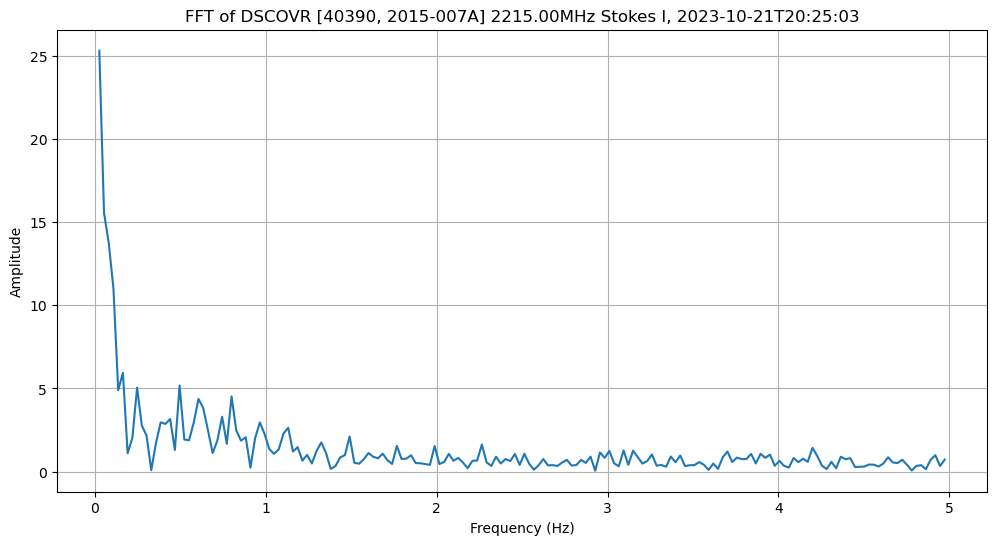

Peak Frequency in FFT of Stokes I: 0.027624309392265192 Hz


In [16]:
time_range_filter = (t >= start_time) & (t <= end_time)
filtered_t = t[time_range_filter]
filtered_I = I[time_range_filter]

mark_size = 5

# Calculate the FFT of Stokes I
freq_I, fft_I = calculate_fft(filtered_I, sample_rate)

# Keep only the positive frequencies and filter out zeros
positive_freq_I = freq_I[(freq_I >= 0) & (freq_I != 0)]
positive_fft_I = np.abs(fft_I[(freq_I >= 0) & (freq_I != 0)])

# Continue with the plotting code
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(positive_freq_I, positive_fft_I, markersize=mark_size)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
title_text = f'FFT of {object_observed} {frequency}MHz Stokes I, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_I_fft.png'
plt.savefig(filename)

plt.show()

peak_frequency_I = positive_freq_I[np.argmax(positive_fft_I)]

print(f"Peak Frequency in FFT of Stokes I: {  peak_frequency_I} Hz")

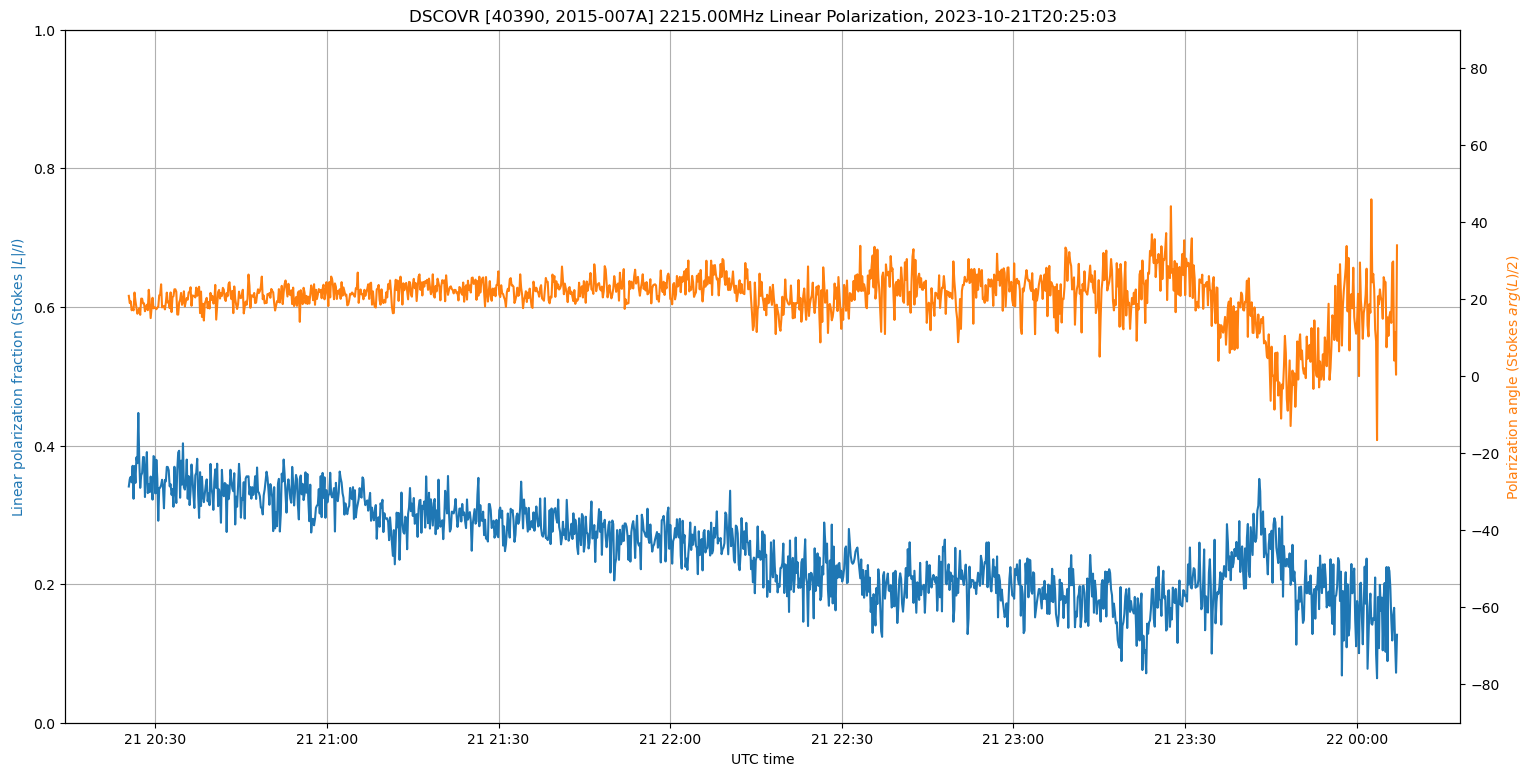

In [17]:
plt.figure(figsize = (18, 9))
plt.plot(t[sel], (np.abs(L)/I)[sel],  markersize=mark_size)
plt.grid(True)

plt.ylim((0,1))
plt.xlabel('UTC time')
plt.ylabel('Linear polarization fraction (Stokes $|L|/I$)', color = 'C0')
ax2 = plt.gca().twinx()
plt.plot(t[sel], np.rad2deg(np.angle(L[sel])/2), color = 'C1', markersize=mark_size)
ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color = 'C1')
ax2.set_ylim((-90,90))
title_text = f'{object_observed} {frequency}MHz Linear Polarization, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_lin_pol.png'
plt.savefig(filename)

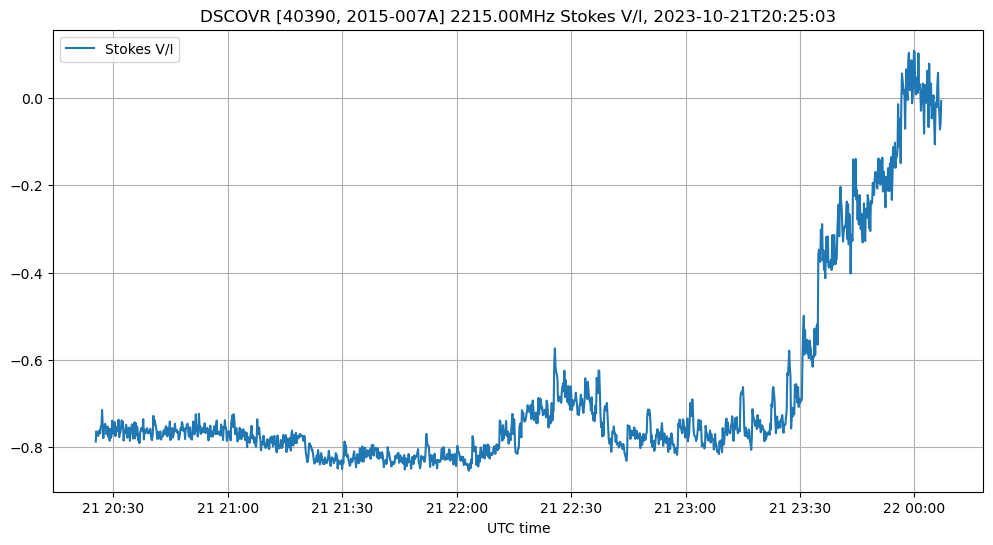

In [18]:
mark_size = 5
plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(t[sel], (V/I)[sel],  markersize=mark_size)
plt.legend(['Stokes V/I'])
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes V/I, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_V_I.png'
plt.savefig(filename)

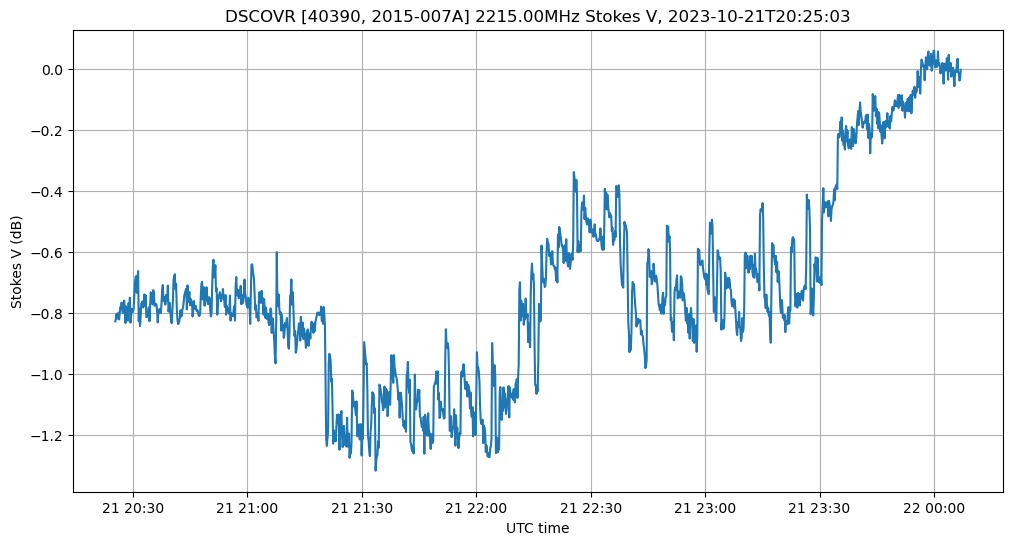

In [19]:
y_min = -1.25  # Set your desired minimum Y value
y_max = 0   # Set your desired maximum Y value

plt.figure(figsize=(12, 6))
plt.grid(True)

plt.plot(t[sel], (V)[sel])
plt.xlabel('UTC time')
plt.ylabel('Stokes V (dB)')

# Set the Y-axis limits
#plt.ylim(y_min, y_max)

title_text = f'{object_observed} {frequency}MHz Stokes V, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_V.png'
plt.savefig(filename)
